In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import polars as pl
from scipy import stats
import matplotlib.pyplot as plt

import os
import utils

1. fare i residuals regression on factors
2. Verificare mean reversion dei residual.


## Variables:
* Stock ($i$) returns: $R_{i, t}, \quad i=1, \dots, N$ or $R_t \in \mathbb{R}^N$
* Factor ($j$) returns: $f_{j, t}, \quad j=1, \dots, p$ or $f_t \in \mathbb{R}^p$
* Exposures: $X_t \in \mathbb{R}^{N\times p}$ or $x_i \in \mathbb{R}^p$, $i = 1, \dots, N$
* Factor covariance: $\Omega_t \in \mathbb{R}^{p\times p}$
* Stocks covariance: $\Sigma_t \in \mathbb{R}^{N\times N}$
* Stocks residual covariance: $D_t \in \mathbb{R}^{N \times N}$, typically diagonal
* Portfolio: (any) $h \in \mathbb{R}^N$

### Regression
At each $t=1, \dots, T$,
$$
R_i = f^Tx_i + \tilde{R_i} \quad \forall i=1, \dots, N
$$
Or:
$$
R = Xf + \tilde{R}
$$
Get
$$
\begin{aligned}
\hat{f_t} &= (X^TD^{-1}X)^{-1}X^TD^{-1}R_i \\
\hat{\tilde{R_i}} &= R - X\hat{f_t}
\end{aligned}
$$
And we have:
$$
X^T\hat{\tilde{R_i}} = 0 \in \mathbb{R}^p
$$

### Covariances

$$
\Sigma = \text{Cov}(R) = \text{Cov}(Xf) + \text{Cov}(\tilde R) = X\Omega X^T + D
$$

### Exposures

* $X_i \in \mathbb{R}^p$: exposure of stock $i$ to each of the $p$ factors;
* Given a portfolio $h \in \mathbb{R}^N$, we have: $X^Th \in \mathbb{R}^p$ is the exposure of the portfolio to each of the factors

### Explore some data

In [3]:
data_path = './test_data'
os.listdir(data_path)

['cov20030102.parquet',
 'cov20030103.parquet',
 'cov20030106.parquet',
 'cov20030107.parquet',
 'cov20030108.parquet',
 'cov20030109.parquet',
 'data20030102.parquet',
 'data20030103.parquet',
 'data20030106.parquet',
 'data20030107.parquet',
 'data20030108.parquet',
 'data20030109.parquet']

In [4]:
%time cov = pl.read_parquet(os.path.join(data_path, 'cov20030102.parquet'))
%time data = pl.read_parquet(os.path.join(data_path, 'data20030102.parquet'))

Wall time: 9.8 ms
Wall time: 8.05 ms


In [5]:
data = data.filter(pl.col('IssuerMarketCap') >= 1e9)

In [6]:
print(data.shape)
data.head()

(1756, 93)


ID,1DREVRSL,AERODEF,AIRLINES,ALUMSTEL,APPAREL,AUTO,BANKS,BETA,BEVTOB,BIOLIFE,BLDGPROD,CHEM,CNSTENG,CNSTMACH,CNSTMATL,COMMEQP,COMPELEC,COMSVCS,CONGLOM,CONTAINR,DISTRIB,DIVFIN,DIVYILD,DWNRISK,EARNQLTY,EARNYILD,ELECEQP,ELECUTIL,FOODPROD,FOODRET,GASUTIL,GROWTH,HLTHEQP,HLTHSVCS,HOMEBLDG,HOUSEDUR,…,OILGSEXP,PAPER,PHARMA,PRECMTLS,PROFIT,PROSPECT,PSNLPROD,REALEST,RESTAUR,RESVOL,ROADRAIL,SEASON,SEMICOND,SEMIEQP,SENTMT,SIZE,SOFTWARE,SPLTYRET,SPTYCHEM,SPTYSTOR,STREVRSL,TELECOM,TRADECO,TRANSPRT,VALUE,WIRELESS,BidAskSpread,DailyVolume,CompositeVolume,IssuerMarketCap,Ret,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
"""ID1000""",-0.837,0.0,0.0,0.0,0.0,0.0,0.0,-2.329,0.0,0.0,0.0,0.082,0.0,0.0,0.0,0.27,0.0,0.0,0.334,0.0,0.0,0.0,-0.869,-0.265,-0.315,0.36,0.0,0.0,0.0,0.0,0.0,1.092,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,-0.206,1.894,0.0,0.0,0.0,-0.089,0.0,0.98,0.0,0.0,-0.294,0.659,0.0,0.0,0.0,0.0,1.064,0.061,0.0,0.0,1.132,0.0,null,null,null,3.4417e10,0.0,0.29274,22.940188,16.825603,-0.000285,0.194528,20030102
"""ID1040""",0.466,0.0,0.0,0.0,0.0,0.0,0.0,-1.486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017,0.239,0.302,0.071,0.0,0.0,0.0,0.0,0.0,0.093,0.0,0.0,0.0,0.0,…,0.0,0.0,1.0,0.0,0.483,1.682,0.0,0.0,0.0,2.726,0.0,-1.9,0.0,0.0,-0.362,0.79,0.0,0.0,0.0,0.0,2.694,0.0,0.0,0.0,-0.708,0.0,null,null,null,1.3104e11,0.0,2.54372,40.735005,34.743207,0.362819,0.595018,20030102
"""ID1100""",-0.53,0.0,0.0,0.0,0.0,0.0,0.0,-2.329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.938,-0.043,-2.559,1.944,0.0,0.498,0.0,0.0,0.0,1.281,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,-0.949,1.894,0.0,0.0,0.0,-1.113,0.0,0.354,0.0,0.0,0.073,-1.601,0.0,0.0,0.0,0.0,1.389,0.0,0.0,0.0,3.011,0.0,null,null,null,1.7584e9,0.0,0.0,35.056218,26.040331,0.000025,0.150303,20030102
"""ID1114""",0.71,0.0,0.0,0.0,0.0,0.0,0.0,-0.211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.125,-1.35,-2.627,2.235,0.0,0.0,0.0,0.0,0.0,0.694,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.061,1.322,0.0,0.0,0.0,1.784,0.0,-0.026,0.0,0.0,0.38,0.051,0.0,0.0,0.0,0.0,-0.606,0.0,0.0,0.0,0.926,0.0,null,593200.0,674100.0,1.5458e10,0.082781,6.098485,49.13487,39.345193,0.911522,1.071357,20030102
"""ID111R""",0.007,0.0,0.0,0.0,0.0,0.0,0.0,-1.027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.938,0.367,-1.167,-0.2,0.0,0.0,0.0,0.0,0.0,1.08,0.0,0.0,0.0,0.0,…,1.0,0.0,0.0,0.0,-0.001,0.513,0.0,0.0,0.0,-0.452,0.0,-0.189,0.0,0.0,0.063,-1.548,0.0,0.0,0.0,0.0,0.477,0.0,0.0,0.0,0.149,0.0,null,915400.0,922900.0,1.8868e9,-0.011693,0.0,22.588669,12.035029,0.560369,0.592904,20030102


In [7]:
print(cov.shape)
cov.head()

(3321, 4)


Factor1,Factor2,VarCovar,DataDate
str,str,f64,i64
"""1DREVRSL""","""1DREVRSL""",3.665058,20030102
"""1DREVRSL""","""BETA""",4.042588,20030102
"""1DREVRSL""","""DIVYILD""",-0.061494,20030102
"""1DREVRSL""","""DWNRISK""",-0.147935,20030102
"""1DREVRSL""","""EARNQLTY""",0.083602,20030102


Cumulative residuals (e.g. 5d reversal)

In [8]:
stocks = data['ID'].to_list()

In [9]:
X = data[['ID'] + utils.all_factors]

In [10]:
ret = data[['ID', 'Ret']]

In [11]:
D = data[['ID', 'SpecRisk']].with_columns(
    pl.col('SpecRisk')/ 100
)
D_inv = D.with_columns(SpecRisk=1. / pl.col('SpecRisk'))
tot_risk = data[['ID', 'TotalRisk']].with_columns(
    pl.col('TotalRisk')/ 100
)

In [12]:
pred_beta = data[['ID', 'PredBeta']]
support = data[['ID', 'BidAskSpread', 'DailyVolume', 'CompositeVolume', 'IssuerMarketCap', 'Yield']]

In [13]:
del data

In [16]:
omega = utils.gordon_to_matrix(cov)
del cov

In [ ]:
sigma = (
    X[:, 1:].to_numpy() @
    omega[:, 1:].to_numpy() @
    X[:, 1:].to_numpy().T
) / 10000
sigma = sigma + np.diag(D['SpecRisk'].to_numpy())**2

#### Estimate factor returns

In [52]:
# estimate factor portfolios
rhs = X[:, 1:].to_numpy().T @ np.diag(D_inv[:, 1].to_numpy())**2
lhs = rhs @ X[:, 1:].to_numpy()

fac_port = np.linalg.solve(lhs, rhs)
del lhs, rhs

(p x N)(N x N)(N x p) -> (p x p)

(p x N)(N x N) -> (p x N)

(p x p)(p x N) -> (p x N)

In [53]:
fac_port = pl.DataFrame(fac_port, schema=stocks)
fac_port.insert_column(0, pl.Series('Factor', utils.all_factors))

Factor,ID1000,ID1040,ID1100,ID1114,ID111R,ID1123,ID112B,ID1130,ID113A,ID1145,ID1161,ID1164,ID116Q,ID119X,ID11AY,ID11BI,ID11BO,ID11BX,ID11FX,ID11GF,ID11GW,ID11HQ,ID11IC,ID11IY,ID11J2,ID11LW,ID11MJ,ID11PM,ID11PN,ID11QM,ID11RS,ID11SN,ID11SO,ID11ST,ID11TF,ID11U2,…,ID3A3H,ID3CEP,ID3CRL,ID3E1P,ID3GSM,ID3HZI,ID3JIN,ID3JWF,ID3JYS,ID3L6X,ID3LUA,ID3M4W,ID3MGQ,ID3MUH,ID3MZB,ID3O2F,ID3QSK,ID3RGU,ID3SBE,ID3THN,ID3TUF,ID3WRU,ID3XDB,ID3Z3R,ID4JHF,ID4JYS,ID4MGQ,ID4O2F,ID4THN,ID5MUH,ID5SXL,ID6SXL,ID7SXL,ID8SXL,ID9SXL,IDASXL,IDFQ3N
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""BETA""",-0.003792,0.000411,-0.001147,0.000267,-0.000983,-0.000121,0.001057,-0.002564,0.000145,-0.000355,0.00126,0.000209,-0.000922,-0.00009,-0.00319,0.000993,0.000539,-0.000244,0.000591,0.000932,0.000245,-0.000837,0.000718,0.000071,-0.000077,0.000396,0.00046,0.000301,-0.000451,0.001391,0.000214,0.000129,0.001419,0.000101,-0.000902,-0.000105,…,-0.001002,-0.003555,0.000221,-0.001952,0.000139,0.002095,-0.000281,0.00042,0.000343,-0.005522,0.00104,0.000628,-0.00132,-0.000358,0.000097,-0.000116,7.7343e-7,-0.00236,0.000296,-0.000066,-0.000806,0.000541,-0.000263,0.000233,0.000133,0.00023,0.000736,-0.001396,0.000232,-0.000301,-0.001871,-0.00174,-0.002774,-0.002037,-0.002338,-0.002561,-0.000147
"""SIZE""",0.001136,-0.000113,-0.000153,-0.0001,-0.00174,0.000888,-0.003081,0.000007,-0.000143,0.000157,0.000205,0.000141,0.00114,0.000777,0.003424,0.002083,0.001083,0.000067,-0.000069,0.000883,0.000169,-0.002951,-0.000244,-0.00295,-0.001783,0.001356,0.004672,0.000052,-0.001383,0.000473,0.000163,-0.000399,-0.000599,0.001802,0.000079,0.000495,…,0.001959,0.00164,-0.000149,-0.002263,-0.002671,-0.000637,0.000624,0.000392,0.000733,0.002943,-0.000152,-0.000112,0.005064,0.007323,-0.000039,0.000293,0.000967,-0.005934,0.011458,0.000562,0.001012,-0.000148,0.001039,-0.002915,-0.000261,-0.000016,0.002428,0.002998,0.000404,0.00539,-0.00023,-0.000609,-0.000029,-0.000586,-0.000226,-0.000731,0.006112
"""MOMENTUM""",-0.000612,0.0015,0.000342,-0.000302,0.000319,-0.000228,0.001851,-0.001383,-0.000197,-0.000508,-0.000274,0.000189,-0.000492,0.000149,-0.001522,0.002101,0.000632,0.000435,0.000007,-0.000086,-0.001522,-0.001183,-0.000267,0.001912,-0.000445,-0.000568,0.000178,-0.000368,-0.000186,0.000755,0.000552,-0.000517,0.000869,-0.000832,-0.000872,0.000658,…,-0.000972,-0.000008,-0.001345,-0.001479,-0.000348,0.00191,0.000045,-0.000459,0.000799,-0.001741,0.000575,0.000018,0.000977,-0.000576,-0.001038,-0.0006,0.000236,-0.003425,0.00073,0.00004,-0.001648,-0.000702,-0.000277,0.000612,-0.000916,-0.000132,0.001251,0.001236,0.000351,-0.000239,-0.000588,-0.000548,-0.000713,-0.000218,-0.000297,-0.001096,-0.00038
"""VALUE""",0.00111,0.00011,0.001267,-0.000197,-0.000304,-0.001176,0.00052,0.00011,0.00005,-0.000725,0.000495,0.000168,-0.000333,-0.002289,0.000033,0.001279,0.00038,0.000802,-0.000304,-0.000315,-0.00012,-0.002479,0.000256,0.003113,-0.000101,0.000076,0.000354,0.000353,0.001487,0.000584,-0.000091,-0.000918,0.000172,0.000722,-0.000862,-0.000111,…,-0.001206,0.002918,-0.000155,-0.000673,0.000072,0.002153,-0.000549,0.0004,-0.001163,-0.003505,0.001553,0.00065,0.001603,0.000474,-0.00088,0.000311,0.000626,0.000429,0.001729,0.000721,0.000877,-0.001197,-0.000073,-0.001754,0.000056,-0.000339,0.001423,0.003024,0.000767,0.000106,-0.001109,-0.000928,-0.000903,-0.001197,0.001112,-0.00069,0.001323
"""GROWTH""",0.001932,-0.000023,0.001326,0.000516,0.001693,0.000297,-0.000729,-0.000978,0.000105,-0.000745,0.000357,-0.000081,0.000286,-0.000988,0.001361,0.000282,-0.000092,0.000361,0.000006,0.000492,0.000831,-0.000317,0.000541,0.000523,0.00159,-0.000305,-0.000532,0.000093,-0.001546,0.000779,-0.000225,-0.000378,-0.001335,0.000624,-0.000156,0.000181,…,0.002193,0.004766,-0.000356,0.000393,0

In [64]:
# example
size_port = fac_port[1, 1:].to_numpy().T
np.isclose(X[:, 1:].to_numpy().T @ size_port, 0).sum()

80

In [65]:
len(utils.all_factors)

81

In [76]:
# now returns
facret = pl.DataFrame(
    fac_port[:, 1:].to_numpy() @ ret[:, 1:].to_numpy(),
    schema=['FacRet']
)
facret.insert_column(0, pl.Series('Factor', utils.all_factors))

Factor,FacRet
str,f64
"""BETA""",0.007593
"""SIZE""",0.001756
"""MOMENTUM""",-0.002163
"""VALUE""",0.000297
"""GROWTH""",-0.000328
…,…
"""SPTYSTOR""",0.007425
"""TELECOM""",0.03945
"""TRADECO""",0.010252


<AxesSubplot:xlabel='Factor'>

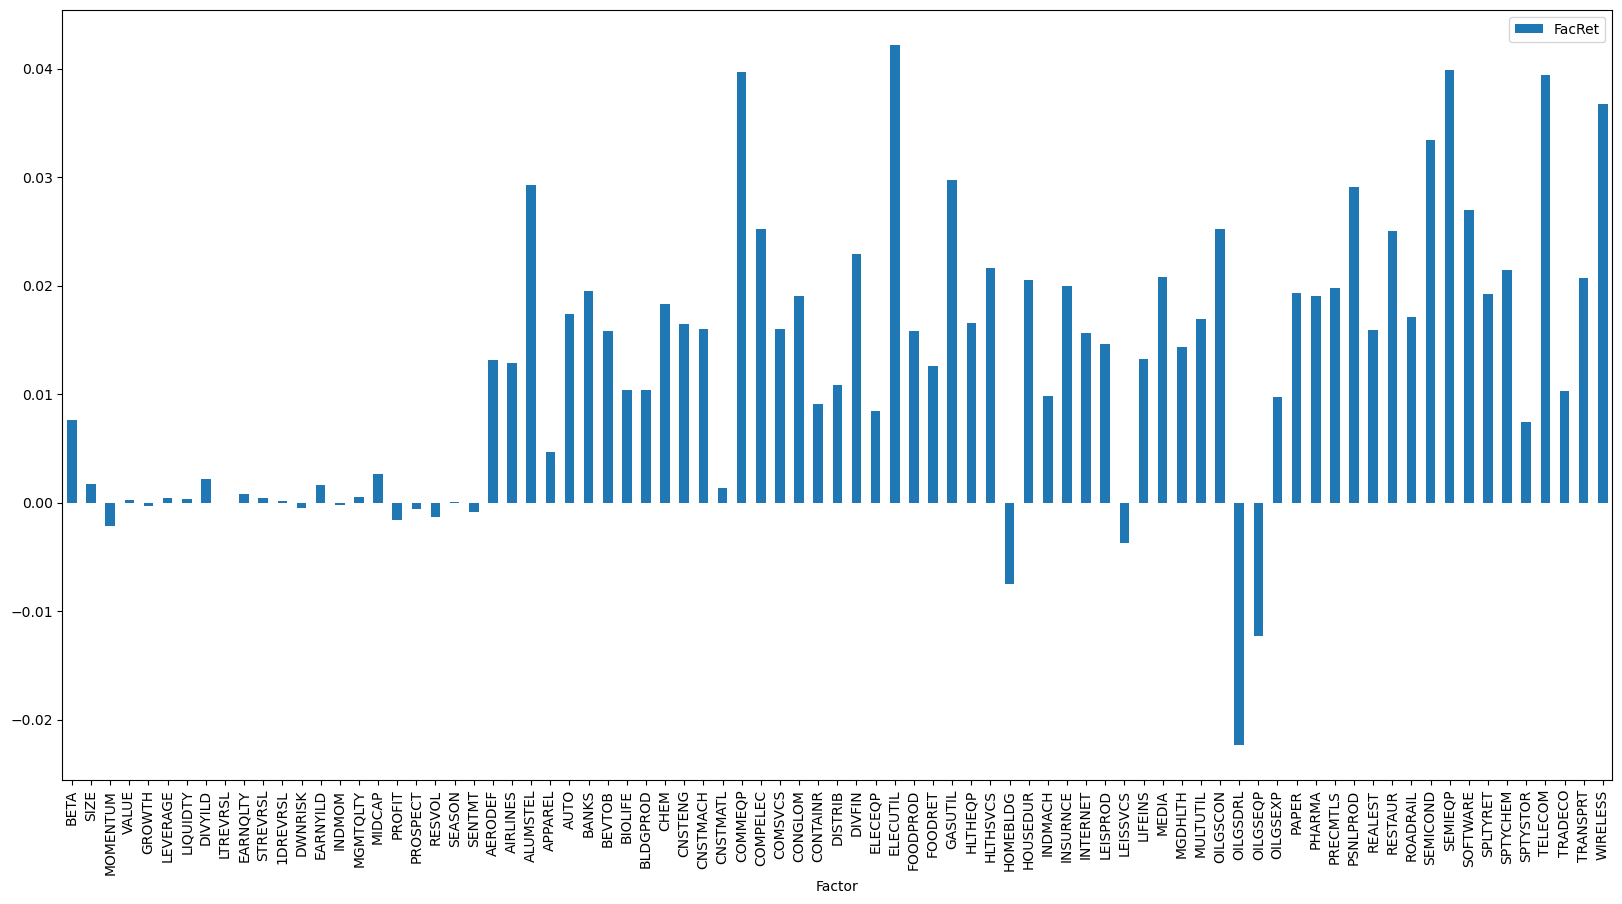

In [77]:
facret.to_pandas().set_index('Factor').plot.bar(figsize=(20, 10))

## Residuals (finally)

In [81]:
fitted = pl.DataFrame(
    X[:, 1:].to_numpy() @ facret[:, 1:].to_numpy(),
    schema=['ResidualRet']
)
fitted.insert_column(0, pl.Series('ID', stocks))

ID,ResidualRet
str,f64
"""ID1000""",0.003226
"""ID1040""",-0.002349
"""ID1100""",0.014582
"""ID1114""",0.02934
"""ID111R""",-0.002736
…,…
"""ID7SXL""",0.006383
"""ID8SXL""",0.005776
"""ID9SXL""",0.00738


In [86]:
fitted = fitted.with_columns(
    z_score=(pl.col('ResidualRet') - pl.col('ResidualRet').mean()) / pl.col('ResidualRet').std()
)

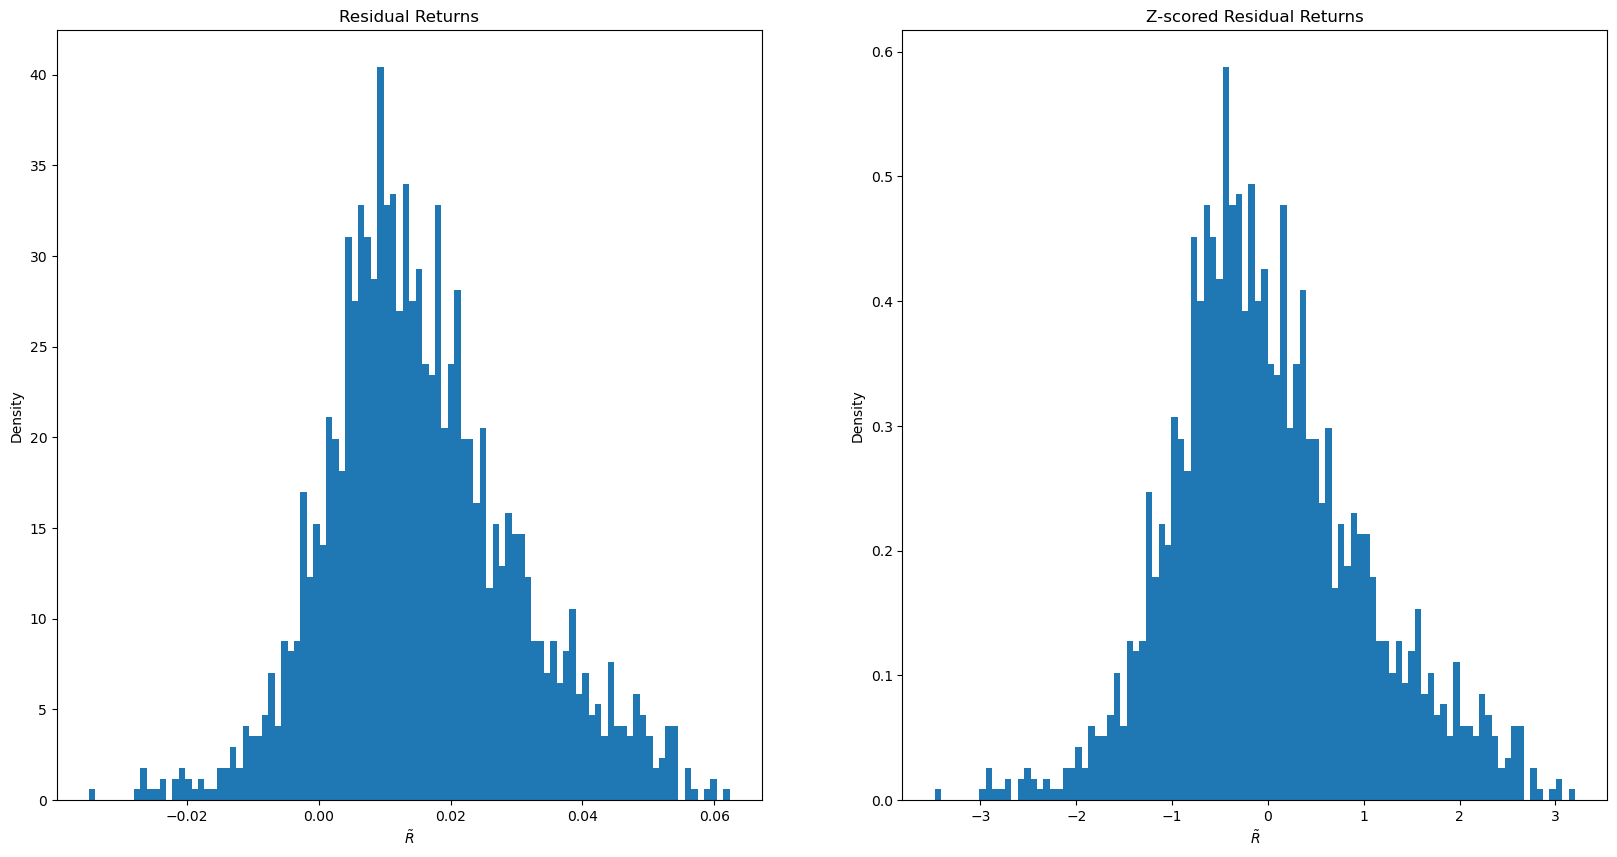

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].hist(fitted['ResidualRet'], bins=100, density=True)
axs[1].hist(fitted['z_score'], bins=100, density=True)
axs[0].set_title('Residual Returns'); axs[1].set_title('Z-scored Residual Returns')
for ax in axs:
    ax.set_xlabel(r'$\tilde{R}$'); ax.set_ylabel('Density')
plt.show()